In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import os
import pandas as pd
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd

from utils import TextTransform
from utils import cer
from utils import wer

from espnet.nets.pytorch_backend.transformer.embedding import PositionalEncoding
from espnet.nets.pytorch_backend.transformer.encoder_layer import EncoderLayer
from espnet.nets.pytorch_backend.transformer.repeat import repeat
from espnet.nets.pytorch_backend.transformer.attention import MultiHeadedAttention
from espnet.nets.pytorch_backend.transformer.positionwise_feed_forward import PositionwiseFeedForward
from espnet.nets.pytorch_backend.transformer.layer_norm import LayerNorm
from espnet.nets.pytorch_backend.nets_utils import make_pad_mask

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
train_audio_transforms = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160, n_mels=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                                              n_fft=400,
                                                              hop_length=160,
                                                              n_mels=80)

text_transform = TextTransform()


def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0])
        label_lengths.append(len(label))

    spectrograms = torch.nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths


def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

In [3]:
class TransformerModel(torch.nn.Module):

    def __init__(
        self,
        input_size=80,
        output_size=29,
        conv2d_filters=32,
        attention_dim=360,
        attention_heads=8,
        feedforward_dim=1024,
        num_layers=10,
        dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        
        self.conv_in = torch.nn.Sequential(
            torch.nn.Conv2d(1, conv2d_filters, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(conv2d_filters, conv2d_filters, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            torch.nn.ReLU(),
        )
        self.conv_out = torch.nn.Sequential(
            torch.nn.Linear(conv2d_filters * ((input_size // 2) // 2), attention_dim),
            PositionalEncoding(attention_dim, 0.1),
        )
        positionwise_layer = PositionwiseFeedForward
        positionwise_layer_args = (attention_dim, feedforward_dim, dropout)
        self.encoder_layer = repeat(
            num_layers,
            lambda lnum: EncoderLayer(
                attention_dim,
                MultiHeadedAttention(
                    attention_heads, attention_dim, dropout
                ),
                positionwise_layer(*positionwise_layer_args),
                dropout,
                normalize_before=True,
                concat_after=False,
            ),
        )
        self.after_norm = LayerNorm(attention_dim)
        self.final_layer = torch.nn.Linear(attention_dim, output_size)

    def forward(self, x, ilens):
        x = x.unsqueeze(1)  # (b, c, t, f)
        x = self.conv_in(x)
        b, c, t, f = x.size()
        x = self.conv_out(x.transpose(1, 2).contiguous().view(b, t, c * f))
        masks = (~make_pad_mask(ilens)[:, None, :])[:, :, ::4].to(x.device)
        x, _ = self.encoder_layer(x, masks)
        x = self.after_norm(x)
        x = self.final_layer(x)
        return x

In [4]:
def train(model, device, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    data_len = len(train_loader.dataset)

    for batch_idx, _data in tqdm(enumerate(train_loader),
                                total=len(train_loader),
                                desc='Train epoch {}'.format(epoch)
                                ):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms[:, :, :,:max(input_lengths)].to(device), labels.to(device) #(batch, 1, feat_dim, time)
        spectrograms = spectrograms.squeeze(1).transpose(1,2) # (batch, time, feat_dim,)
        optimizer.zero_grad()
        
        output = model(spectrograms, input_lengths)  # (batch, time, n_classes)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)
        input_lengths = [x // 4 for x in input_lengths]

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        scheduler.step()
        
    return loss
        


def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for i, _data in tqdm(enumerate(test_loader),
                            total=len(test_loader),
                            desc='Test epoch {}'.format(epoch)                            
                            ):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            spectrograms = spectrograms.squeeze(1).transpose(1,2) # (batch time, feat_dim,)
            
            output = model(spectrograms, input_lengths)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)
            input_lengths = [x // 4 for x in input_lengths]

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))
    
    return test_loss, avg_cer, avg_wer

In [5]:
def main(learning_rate=1e-5, batch_size=20, test_batch_size=7, epochs=10,
        train_url="train-clean-100", test_url="test-clean", model_path='baseline'):
    
    hparams = {
        "input_size": 80,
        "output_size": 29,
        "conv2d_filters": 32,
        "attention_dim": 360,
        "attention_heads": 8,
        "feedforward_dim": 1024,
        "num_layers":10,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda")

    if not os.path.isdir("./data"):
        os.makedirs("./data")

    train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=train_url, download=True)
    test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=test_url, download=True)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'train'),
                                **kwargs)
    test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=test_batch_size,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid'),
                                **kwargs)

    model = TransformerModel(
        hparams['input_size'],
        hparams['output_size'],
        hparams['conv2d_filters'],
        hparams['attention_dim'],
        hparams['attention_heads'],
        hparams['feedforward_dim'],
        hparams['num_layers'],
        hparams['dropout']).to(device)

    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = torch.nn.CTCLoss(blank=28, zero_infinity=False).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=hparams['epochs'],
                                            anneal_strategy='linear')

    result = {
            'train_loss': [],
            'test_loss':[],
            'cer':[],
            'wer':[],
         }
        
    for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, criterion, optimizer, scheduler, epoch)
        test_loss, cer, wer = test(model, device, test_loader, criterion, epoch)
        
        result['train_loss'].append(train_loss)
        result['test_loss'].append(test_loss)
        result['cer'].append(cer)
        result['wer'].append(wer)
        
    with open(f"{model_path}.pth", "wb") as fp:
        torch.save(model.state_dict(), fp)

    return result

In [6]:
learning_rate = 1e-3
batch_size = 10
test_batch_size = 7
epochs = 10
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"
TRAINED = True

if TRAINED:
    result_baseline = pd.read_csv('resources/result-lab-02-04/metrics_baseline.csv', index_col=0)
else:
    result = main(learning_rate, batch_size, test_batch_size, epochs, libri_train_set, libri_test_set)
    df = pd.DataFrame(result)
    df['train_loss'] = df['train_loss'].apply(lambda x: x.tolist())
    df.to_csv('resources/result-lab-02-04/metrics_baseline.csv')
    result_baseline = pd.read_csv('resources/result-lab-02-04/metrics_baseline.csv', index_col=0)

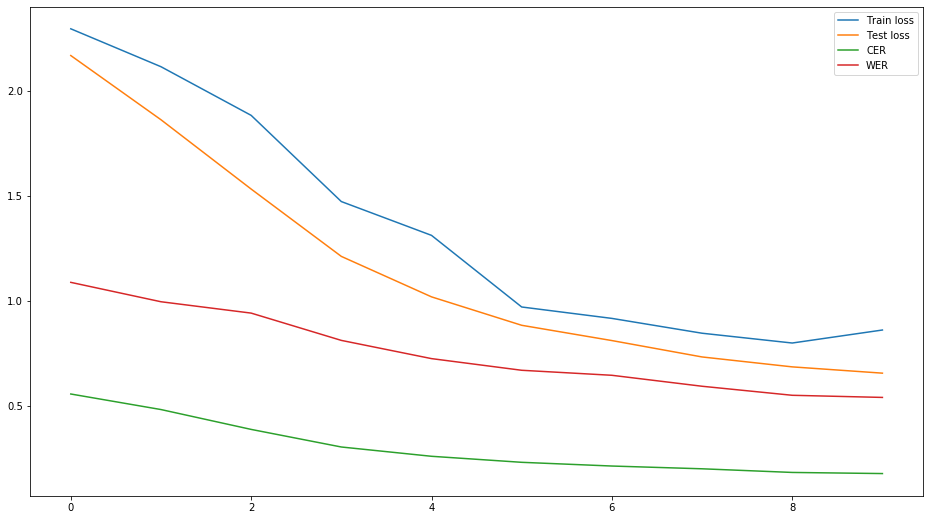

In [7]:
plt.figure(figsize=(16, 9))
plt.plot(result_baseline['train_loss'], label='Train loss')
plt.plot(result_baseline['test_loss'], label='Test loss')
plt.plot(result_baseline['cer'], label='CER')
plt.plot(result_baseline['wer'], label='WER')
plt.legend()
plt.show()

### <b>Задание №1</b> (5 баллов):
На данный момент практически все E2E SOTA решения использую [сабворды](https://dyakonov.org/2019/11/29/%D1%82%D0%BE%D0%BA%D0%B5%D0%BD%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F-%D0%BD%D0%B0-%D0%BF%D0%BE%D0%B4%D1%81%D0%BB%D0%BE%D0%B2%D0%B0-subword-tokenization/) (subwords/wordpieces) в качестве таргетов нейронки для распознавания. Нам бы тоже не мешало перейти от графем к сабвордам. Теперь вместо букв (графем) будем распознавать кусочки слов. В качестве такого токенайзера предлагается использовать [Sentencepiece](https://github.com/google/sentencepiece). Главное правильно обернуть его в наш класс TextTransform. Текстовый файл (train_clean_100_text_clean.txt) для обучения токенайзера уже подготовлен и лежит в корневой папке проекта. 

In [8]:
import sentencepiece as spm

In [9]:
class TextTransformBPE:
    def __init__(self, train_text):
        spm.SentencePieceTrainer.train(
        f'--input={train_text} --model_type=bpe --model_prefix=resources/result-lab-02-04/m --vocab_size=4000')
        self.sp = spm.SentencePieceProcessor()
        self.sp.load('resources/result-lab-02-04/m.model')
        
    def text_to_int(self, text):
        """ Преобразование входного текста в последовательность сабвордов в формате их индекса в BPE модели """
        return self.sp.encode_as_ids(text)

    def int_to_text(self, labels):
        """ Преобразование последовательности индексов сабвордов в текст """
        labels = list(map(int, labels))
        return self.sp.decode(labels)

In [10]:
text_transform_bpe = TextTransformBPE('resources/train_clean_100_text_clean.txt')

In [11]:
def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.Tensor(text_transform_bpe.text_to_int(utterance))
        labels.append(label)
        input_lengths.append(spec.shape[0])
        label_lengths.append(len(label))

    spectrograms = torch.nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

In [12]:
def GreedyDecoder(output, labels, label_lengths, blank_label=4000, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = [] 
        targets.append(text_transform_bpe.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform_bpe.int_to_text(decode))
    return decodes, targets

In [13]:
def main(learning_rate=1e-5, batch_size=20, test_batch_size=7, epochs=10,
        train_url="train-clean-100", test_url="test-clean", model_path='baseline'):
    
    hparams = {
        "input_size": 80,
        "output_size": 4001,
        "conv2d_filters": 32,
        "attention_dim": 360,
        "attention_heads": 8,
        "feedforward_dim": 1024,
        "num_layers":10,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda")

    if not os.path.isdir("./data"):
        os.makedirs("./data")

    train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=train_url, download=True)
    test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=test_url, download=True)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'train'),
                                **kwargs)
    test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=test_batch_size,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid'),
                                **kwargs)

    model = TransformerModel(
        hparams['input_size'],
        hparams['output_size'],
        hparams['conv2d_filters'],
        hparams['attention_dim'],
        hparams['attention_heads'],
        hparams['feedforward_dim'],
        hparams['num_layers'],
        hparams['dropout']).to(device)

    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = torch.nn.CTCLoss(blank=4000, zero_infinity=False).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=hparams['epochs'],
                                            anneal_strategy='linear')

    result = {
            'train_loss': [],
            'test_loss':[],
            'cer':[],
            'wer':[],
         }
        
    for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, criterion, optimizer, scheduler, epoch)
        test_loss, cer, wer = test(model, device, test_loader, criterion, epoch)
        
        result['train_loss'].append(train_loss)
        result['test_loss'].append(test_loss)
        result['cer'].append(cer)
        result['wer'].append(wer)
        
    with open(f"{model_path}.pth", "wb") as fp:
        torch.save(model.state_dict(), fp)

    return result

In [14]:
learning_rate = 1e-3
batch_size = 10
test_batch_size = 7
epochs = 20
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"
TRAINED = True

if TRAINED:
    result_bpe = pd.read_csv('resources/result-lab-02-04/metrics_bpe.csv', index_col=0)
else:
    result_bpe = main(learning_rate, batch_size, test_batch_size, epochs, libri_train_set, libri_test_set, model_path='BPE')
    df = pd.DataFrame(result_bpe)
    df['train_loss'] = df['train_loss'].apply(lambda x: x.tolist())
    df.to_csv('resources/result-lab-02-04/metrics_bpe.csv')
    result_bpe = pd.read_csv('resources/result-lab-02-04/metrics_bpe.csv', index_col=0)

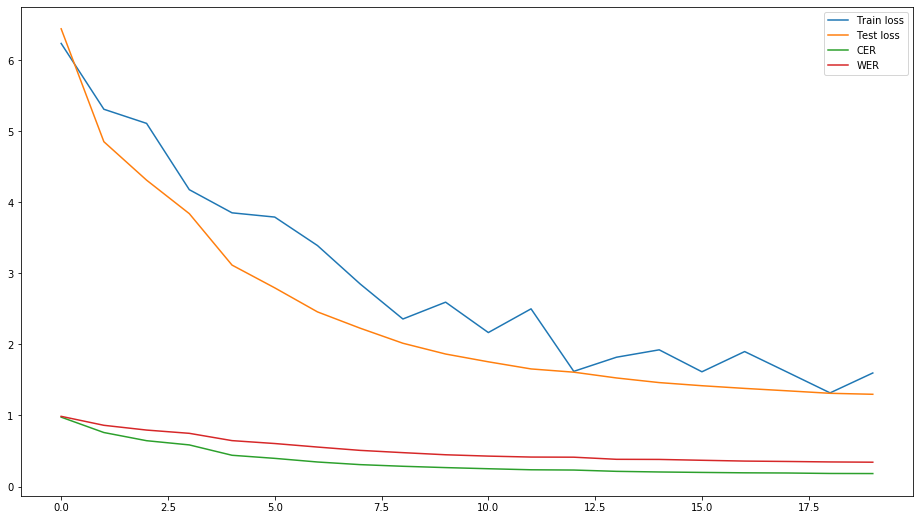

In [15]:
plt.figure(figsize=(16, 9))
plt.plot(result_bpe['train_loss'], label='Train loss')
plt.plot(result_bpe['test_loss'], label='Test loss')
plt.plot(result_bpe['cer'], label='CER')
plt.plot(result_bpe['wer'], label='WER')
plt.legend()
plt.show()

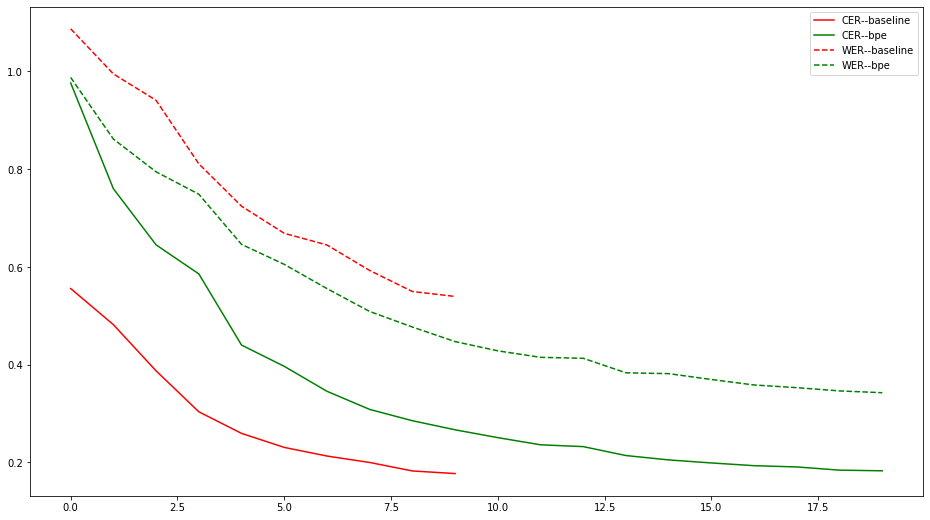

In [16]:
plt.figure(figsize=(16, 9))
plt.plot(result_baseline['cer'], label='CER--baseline', color='r')
plt.plot(result_bpe['cer'], label='CER--bpe', color='g')
plt.plot(result_baseline['wer'], label='WER--baseline', color='r', linestyle = '--')
plt.plot(result_bpe['wer'], label='WER--bpe', color='g', linestyle = '--')
plt.legend()
plt.show()

### <b>Задание №2</b> (5 баллов):
Импровизация по улучшению качества распознавания.

In [17]:
from espnet.nets.pytorch_backend.transformer.repeat import repeat
from espnet.nets.pytorch_backend.conformer.convolution import ConvolutionModule
from espnet.nets.pytorch_backend.transformer.attention import (
    MultiHeadedAttention,  # noqa: H301
    RelPositionMultiHeadedAttention,  # noqa: H301
)
from espnet.nets.pytorch_backend.transformer.embedding import (
    RelPositionalEncoding,  
)
from espnet.nets.pytorch_backend.transformer.multi_layer_conv import Conv1dLinear
from espnet.nets.pytorch_backend.conformer.encoder_layer import EncoderLayer
from espnet.nets.pytorch_backend.transformer.positionwise_feed_forward import (
    PositionwiseFeedForward,
)
from espnet.nets.pytorch_backend.nets_utils import get_activation

In [18]:
class ConformerModel(torch.nn.Module):

    def __init__(
        self,
        input_size=80,
        output_size=4001,
        conv2d_filters=32,
        attention_dim=360,
        attention_heads=4,
        feedforward_dim=1024,
        num_blocks=6,
        dropout=0.1,
        attention_dropout_rate=0.0,
        linear_units=2048,
        activation_type='swish',
        macaron_style=False,
        use_cnn_module=True,
        normalize_before=True,
        concat_after=False,
        cnn_module_kernel=3,
    ):
        super(ConformerModel, self).__init__()
        activation = get_activation(activation_type)

        
        
        self.conv_in = torch.nn.Sequential(
            torch.nn.Conv2d(1, conv2d_filters, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(conv2d_filters, conv2d_filters, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            torch.nn.ReLU(),
        )
        self.conv_out = torch.nn.Sequential(
            torch.nn.Linear(conv2d_filters * ((input_size // 2) // 2), attention_dim),
            PositionalEncoding(attention_dim, 0.1),
        )
    
            
        
        encoder_selfattn_layer = RelPositionMultiHeadedAttention
        encoder_selfattn_layer_args = (
            attention_heads,
            attention_dim,
            attention_dropout_rate,
        )

        positionwise_layer = PositionwiseFeedForward
        positionwise_layer_args = (
            attention_dim,
            linear_units,
            dropout,
            activation,
        )        

        convolution_layer = ConvolutionModule
        convolution_layer_args = (attention_dim, cnn_module_kernel, activation)
        
        self.encoder_layer = repeat(
            num_blocks,
            lambda lnum: EncoderLayer(
                attention_dim,
                encoder_selfattn_layer(*encoder_selfattn_layer_args),
                positionwise_layer(*positionwise_layer_args),
                positionwise_layer(*positionwise_layer_args) if macaron_style else None,
                convolution_layer(*convolution_layer_args) if use_cnn_module else None,
                dropout,
                normalize_before,
                concat_after,
            ),
        )
        self.after_norm = LayerNorm(attention_dim)
        self.final_layer = torch.nn.Linear(attention_dim, output_size)

    def forward(self, x, ilens):
        x = x.unsqueeze(1)  # (b, c, t, f)
        x = self.conv_in(x)
        b, c, t, f = x.size()
        x = self.conv_out(x.transpose(1, 2).contiguous().view(b, t, c * f))
        masks = (~make_pad_mask(ilens)[:, None, :])[:, :, ::4].to(x.device)
        x = self.encoder_layer(x, masks)
        if isinstance (x, tuple):
            x = x[0]
        x = self.after_norm(x)
        x = self.final_layer(x)
        return x

In [19]:
def main(learning_rate=1e-5, batch_size=20, test_batch_size=7, epochs=10,
        train_url="train-clean-100", test_url="test-clean", model_path='baseline'):
    
    hparams = {
        "input_size": 80,
        "output_size": 4001,
        "conv2d_filters": 32,
        "attention_dim": 360,
        "attention_heads": 4,
        "feedforward_dim": 1024,
        "num_blocks": 6,
        "dropout": 0.1,
        "atention_dropout_rate": 0.0,
        "linear_units": 2048,
        "activation_type": 'swish',
        "macaron_style": False,
        "use_cnn_module": True,
        "normalize_before": True,
        "concat_after": False,        
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda:1")

    if not os.path.isdir("./data"):
        os.makedirs("./data")

    train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=train_url, download=True)
    test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=test_url, download=True)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'train'),
                                **kwargs)
    test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=test_batch_size,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid'),
                                **kwargs)

    model = ConformerModel(
        hparams['input_size'],
        hparams['output_size'],
        hparams['conv2d_filters'],
        hparams['attention_dim'],
        hparams['attention_heads'],
        hparams['feedforward_dim'],
        hparams['num_blocks'],
        hparams['dropout']).to(device)

    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = torch.nn.CTCLoss(blank=4000, zero_infinity=False).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=hparams['epochs'],
                                            anneal_strategy='linear')

    result = {
            'train_loss': [],
            'test_loss':[],
            'cer':[],
            'wer':[],
         }
        
    for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, criterion, optimizer, scheduler, epoch)
        test_loss, cer, wer = test(model, device, test_loader, criterion, epoch)
        
        result['train_loss'].append(train_loss)
        result['test_loss'].append(test_loss)
        result['cer'].append(cer)
        result['wer'].append(wer)
        
    with open(f"{model_path}.pth", "wb") as fp:
        torch.save(model.state_dict(), fp)

    return result

In [20]:
learning_rate = 1e-3
batch_size = 10
test_batch_size = 5
epochs = 20
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"
TRAINED = True

if TRAINED:
    result_conf = pd.read_csv('resources/result-lab-02-04/metrics_conf.csv', index_col=0)
else:
    result_conf = main(learning_rate, batch_size, test_batch_size, epochs, libri_train_set, libri_test_set, 
                       model_path='conformer')
    df = pd.DataFrame(result_conf)
    df['train_loss'] = df['train_loss'].apply(lambda x: x.tolist())
    df.to_csv('resources/result-lab-02-04/metrics_conf.csv')
    result_conf = pd.read_csv('resources/result-lab-02-04/metrics_conf.csv', index_col=0)

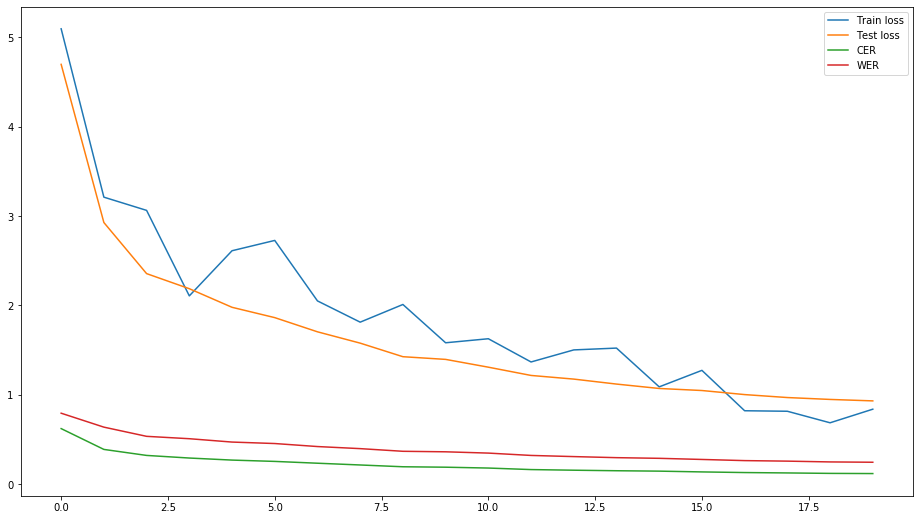

In [21]:
plt.figure(figsize=(16, 9))
plt.plot(result_conf['train_loss'], label='Train loss')
plt.plot(result_conf['test_loss'], label='Test loss')
plt.plot(result_conf['cer'], label='CER')
plt.plot(result_conf['wer'], label='WER')
plt.legend()
plt.show()

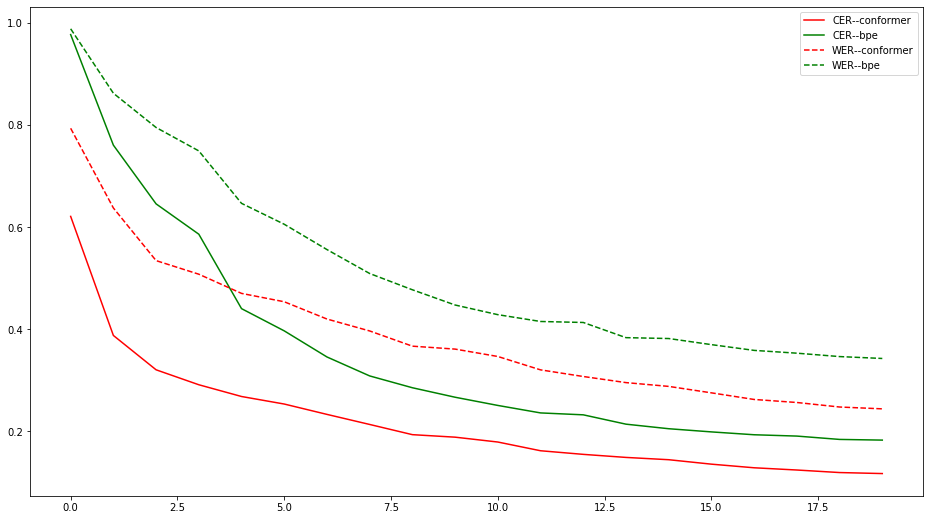

In [22]:
plt.figure(figsize=(16, 9))
plt.plot(result_conf['cer'], label='CER--conformer', color='r')
plt.plot(result_bpe['cer'], label='CER--bpe', color='g')
plt.plot(result_conf['wer'], label='WER--conformer', color='r', linestyle = '--')
plt.plot(result_bpe['wer'], label='WER--bpe', color='g', linestyle = '--')
plt.legend()
plt.show()